# TP Optimisation II:  A simple neural network 

### Nom(s): MOUTAHIR
### Prénom(s): Jed
### Groupe: B2

## Useful packages

In [65]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Loading of the train and test data

In [66]:
#
# Load train data
#
Xtrain = np.load('train-images.npy')
Xtrain = np.array([x.ravel()/255 for x in Xtrain])
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
Ytrain = np.load('train-labels.npy')
targets_train = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytrain:
    v      = np.zeros((10,1))
    v[lab] = 1
    targets_train+=[np.array(v)]

#
# Load test data
#
Xtest        = np.load('t10k-images.npy')
Xtest        = np.array([x.ravel()/255 for x in Xtest])
Xtest        = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
Ytest        = np.load('t10k-labels.npy')
targets_test = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytest:
    v = np.zeros((10,1))
    v[lab]=1
    targets_test+=[np.array(v)]
#
# Outputs
#
print('There are ',Xtrain.shape[0],'images in the train set')
print('There are ',Xtest.shape[0],'images in the test set')

There are  60000 images in the train set
There are  10000 images in the test set


## Definition of the activation function

 The activation function defines the output of a node given a set of inputs. We use the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> function defined by
 
 $$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad s.t. \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [67]:
#
# Nonlinear activation function
#
def softmax(x,alpha):
    """
    Softmax unit activation function 
    x    : Numpy array
    alpha: scalar
    """ 
    
    value = np.exp(alpha+x)/np.sum(np.exp(alpha+x))
    
    return value

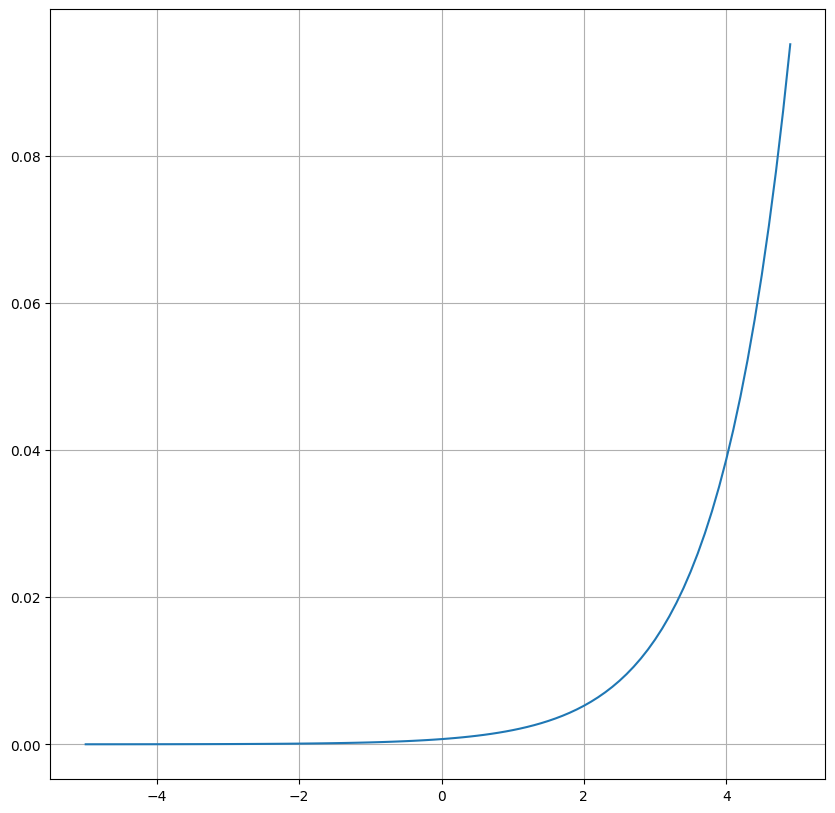

In [68]:
#
# Example of a plot of the activation function
#
t     = np.arange(-5,5,0.1)
alpha = 0. #np.arange(-50,50,1)
plt.figure(figsize=(10,10))
plt.plot(t,softmax(t,alpha))
plt.grid(True)
plt.show()

## Definition of a simple neural network

We use a one-layer fully-connected neural network with the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function.


In [69]:
def NN(x,W):
    """
    # One-layer fully connected neural network
    # x: image, i.e. 784x1 vector (28x28)
    # W: weight matrices of shape 10x784   
    """
    # Compute the output of the network
    pred = softmax(np.dot(W,x),1)
    
    return pred

## Definition of the loss function

The loss function is the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross-entropy</a> defined by 

$J(W)=-\sum_{i=1}^N p_i \log(q_i(W)),$ where $N$ is the number of classes, $(p_i)_{i=1:N}$ are the probabilities of  a data from the training set to belong to a class (0 or 1 because the labels are known), and $(q_i(W))_{i=1:N}$ are the predicted probabilities from the model

$$\forall i=1:N, \quad q_i(W)=[\sigma_{\alpha}(Wx)]_i.$$

In [70]:
#
# Loss function = Cross-entropy
#
def cross_entropy(pred,target,x):
    """
    pred:   predicted probabilities (q(W))
    target: probabilities (p)
    x:      image 
    """ 
    ce = -np.sum(target*np.log(pred))
    #
    # gradient of the cross-entropy
    s = pred
    u    =  np.ones((s.shape[0],1))
    g    = (-u.T.dot(target)*(s.dot(x.T))+target*x.T)
    grad = -g.reshape(x.shape[0]*target.shape[0],1)
    
    return ce,grad
#
# Main function 
#
def f(W,x,target):
    """
    W:      weights
    target: probabilities (p)
    x:      image
    """
    # Compute the output of the network
    pred = NN(x,W)
    # Compute the cross-entropy
    ce,grad = cross_entropy(pred,target,x)
    
    return ce,grad,pred

In [71]:
#
# Test information on the gradient with calls of f
#

# Define weight matrices
W      = np.random.rand(10,Xtrain.shape[1])
eps    = 1e-8
d      = np.random.rand(10,Xtrain.shape[1])
Wtilde = W+eps*d

# Retrieve the information on the gradients
res    = (f(Wtilde,Xtrain[0],targets_train[0])[0]-f(W,Xtrain[0],targets_train[0])[0])/eps
print(res)

g      = f(W,Xtrain[0],targets_train[0])[1]
print(g.T.dot(d.reshape(7840,1)))

-1.5749703763390244
[[-1.57497053]]


## Generating batches 

In [72]:
#
# Function to create batches of samples to be used later in the training phase
#
def create_batches(x,bs):
    """
    x : set to be considered (array)
    bs: batch size (scalar)
    """
    batches = []
    ind     = np.arange(x.shape[0])
    random.shuffle(ind)
    nbatch  = ind.shape[0]//bs
    rest    = ind.shape[0]%bs
    
    for n in range(nbatch):
        batches +=[ind[bs*n:bs*(n+1)]]
    
    # Put the remaining elements in a last batch
    if rest !=0:        
        batches += [ind[-rest:]]
        
    return batches

## Training of the neural network

In [76]:
history    = {}
eta        = 1e-5 # learning rate
momentum   = 0.   # momemtum factor
N_EPOCHS   = 10   # number of epochs  
BatchSizes = [10000,1024,256] # try different batch sizes for the analysis

for bs in BatchSizes:
    #
    # Sensitivity to the batch size to be investigated in the analysis
    #
    print('batch size=',bs)
    
    history[bs]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])
    
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        
        Batches=create_batches(Xtrain,bs)
        
        for batch in Batches:
            # Loop on the batches
            #print('epoch=',n,'batch=',batch.shape[0])
            
            # Store the previous weights
            wold = w
            # Store the previous gradients
            gradold = grad

            # Compute the gradient of the loss function and compute the training loss and accuracy
            train_acc  = 0
            train_loss = 0
            grad = np.zeros((10,Xtrain.shape[1]))
            for i in batch:
                ce, gradtemp, pred = f(w,Xtrain[i],targets_train[i])
                grad += gradtemp.reshape(10,Xtrain.shape[1])
                train_loss += ce
                train_acc  += np.argmax(pred)==np.argmax(targets_train[i])

            history[bs]['train loss'] += [train_loss/batch.shape[0]]
            history[bs]['train acc']  += [train_acc/batch.shape[0]]
        
            # Update the weights
            w = w - eta*grad + momentum*(w-wold)
                   
        # Test accuracy at the end of each epoch on the training set
        

        # Compute the test loss and accuracy
        test_loss = 0
        test_acc  = 0
        for i in range(Xtest.shape[0]):
            pred = NN(Xtest[i],w)
            test_loss += cross_entropy(pred,targets_test[i],Xtest[i])[0]
            test_acc  += np.argmax(pred)==np.argmax(targets_test[i])

        history[bs]['test loss'] += [test_loss/Xtest.shape[0]]
        history[bs]['test acc']  += [test_acc/Xtest.shape[0]]

        print('Epoch number :', n+1,'test accuracy:',history[bs]['test acc'][n+1],'test loss',history[bs]['test loss'][n+1])
        

    print('\n')            

batch size= 10000
Epoch number : 1 test accuracy: 0.1614 test loss 2.951812404501549
Epoch number : 2 test accuracy: 0.2677 test loss 2.3921419709373266
Epoch number : 3 test accuracy: 0.3686 test loss 2.0096890776734386
Epoch number : 4 test accuracy: 0.4476 test loss 1.737725012474268
Epoch number : 5 test accuracy: 0.506 test loss 1.5395442373022323
Epoch number : 6 test accuracy: 0.5532 test loss 1.3906061478974598
Epoch number : 7 test accuracy: 0.5905 test loss 1.2748777840196344
Epoch number : 8 test accuracy: 0.6186 test loss 1.1826026211096914
Epoch number : 9 test accuracy: 0.6421 test loss 1.1075492259398505
Epoch number : 10 test accuracy: 0.6611 test loss 1.0450300748067418


batch size= 1024
Epoch number : 1 test accuracy: 0.1402 test loss 3.165979818253336
Epoch number : 2 test accuracy: 0.2198 test loss 2.599094664252375
Epoch number : 3 test accuracy: 0.3181 test loss 2.192519443481473
Epoch number : 4 test accuracy: 0.3939 test loss 1.8947896255177885
Epoch number : 5

In [80]:
# last value for the test accuracy
print('Test accuracy for batch size =',BatchSizes[0],':',history[BatchSizes[0]]['test acc'][-1])
print('Test accuracy for batch size =',BatchSizes[1],':',history[BatchSizes[1]]['test acc'][-1])
print('Test accuracy for batch size =',BatchSizes[2],':',history[BatchSizes[2]]['test acc'][-1])

Test accuracy for batch size = 10000 : 0.6611
Test accuracy for batch size = 1024 : 0.631
Test accuracy for batch size = 256 : 0.6458


## Plots of the evolution of the loss function

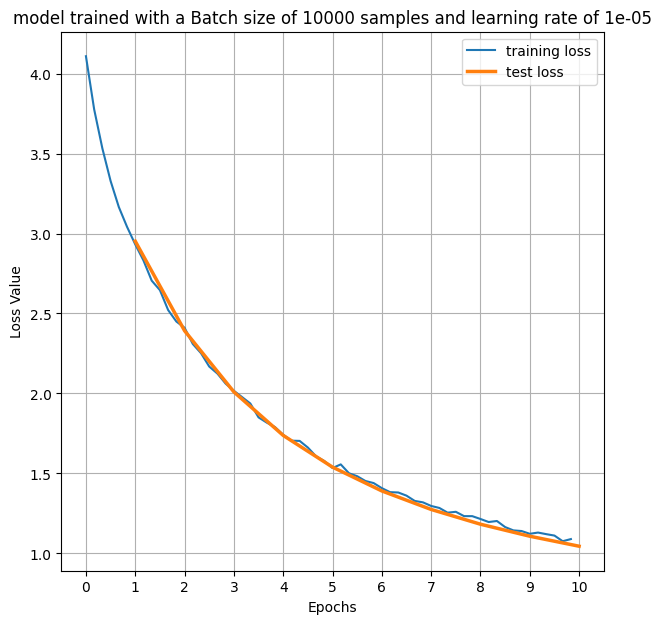

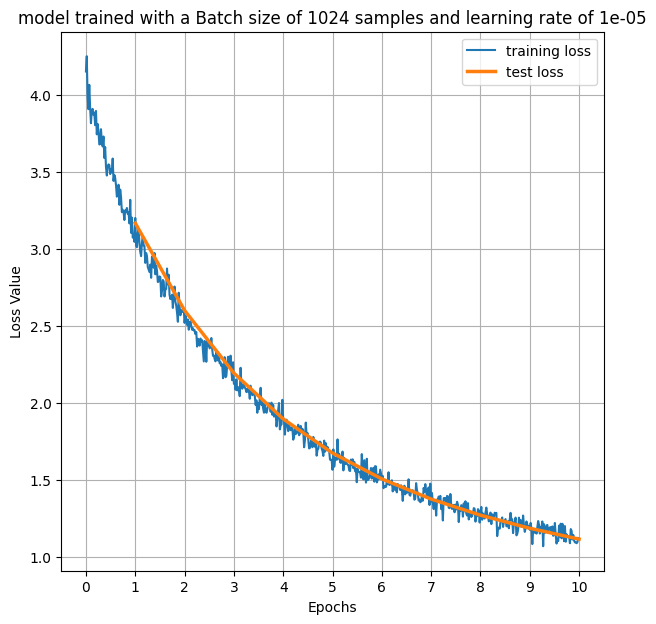

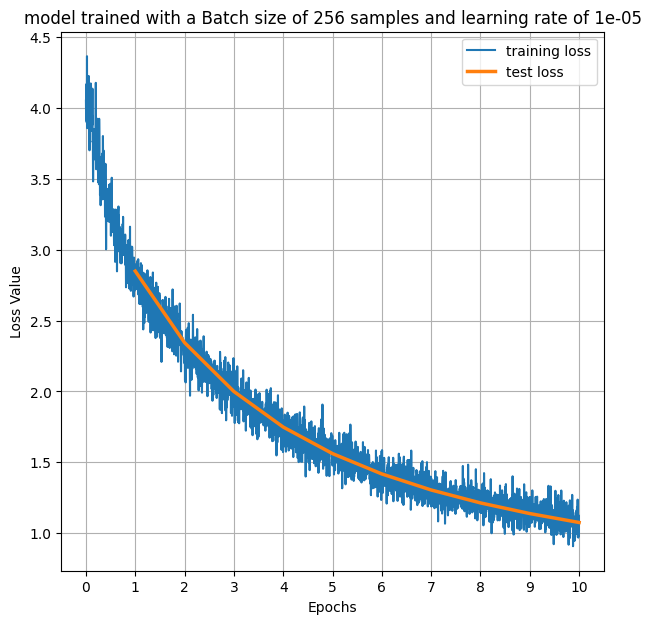

In [77]:
for bs in BatchSizes:
       
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[bs]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.show()

## Plots of the evolution of the accuracy

10000
6


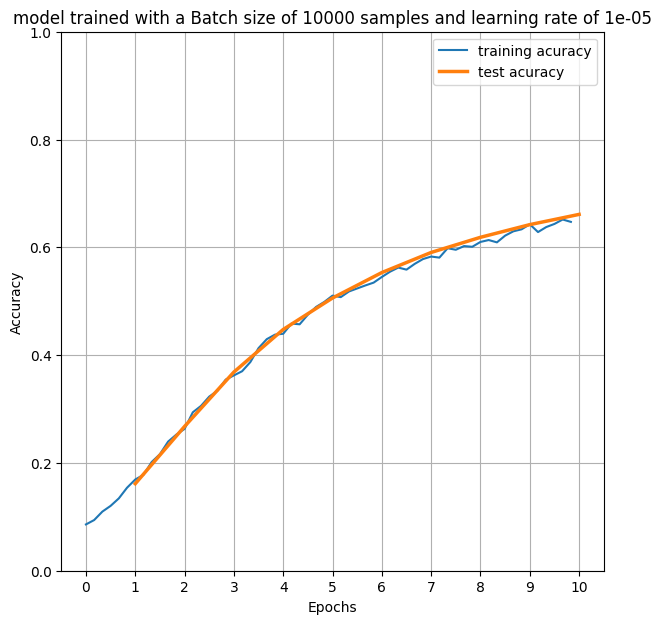

1024
59


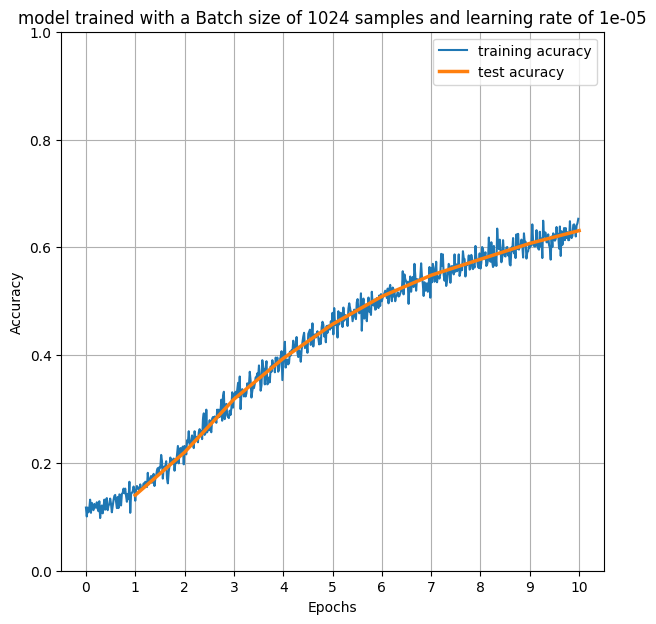

256
235


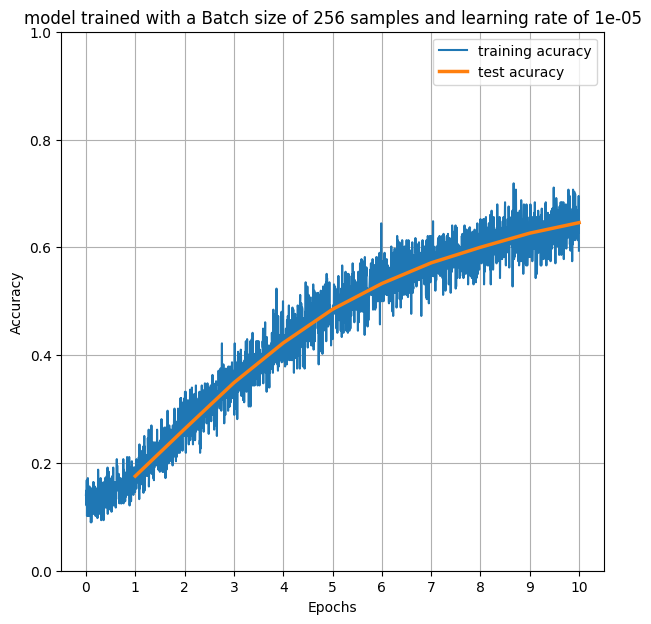

In [78]:
for bs in BatchSizes:
    print(bs)   
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    print(n_batch)
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[bs]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Analysis of the results

Please provide your comments on the sensitivity of the results to the parameters involved in the learning process (batch size, learning rate, momentum).

### Your comments:

## Sensivity to batch size
The batch size is the number of samples that will be propagated through the network. The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. The batch size must be more than 1 and less than the total number of samples in the training dataset. The batch size is a trade-off between the number of training epochs to train the model and the amount of memory required to store the model.
Hence, the smaller the batch size, the more updates there are to the model and the more training epochs are required to train the model. The larger the batch size, the more memory is required to train the model.
Otherwise, it has no effect on the accuracy of the model.

## Sensivity to the learning rate
The learning rate is a hyperparameter that controls how much to update the model in response to the estimated error each time the model weights are updated. The learning rate must be chosen carefully, and often a small learning rate is chosen, such as 0.1 or 0.01. The learning rate must be chosen carefully, and often a small learning rate is chosen, such as 0.1 or 0.01. A large learning rate can result in a model that learns very quickly but may not converge, whereas a small learning rate may result in a model that takes a long time to learn and may not converge. A large learning rate can result in a model that learns very quickly but may not converge, whereas a small learning rate may result in a model that takes a long time to learn and may not converge.

learning rate= 1e-05
Epoch number : 1 test accuracy: 0.1435 test loss 3.1758457698587255
Epoch number : 2 test accuracy: 0.2431 test loss 2.5745265711927354
Epoch number : 3 test accuracy: 0.335 test loss 2.1660790209406406
Epoch number : 4 test accuracy: 0.407 test loss 1.8658906717669208
Epoch number : 5 test accuracy: 0.4695 test loss 1.6427420840428764
Epoch number : 6 test accuracy: 0.5187 test loss 1.4732467447312851
Epoch number : 7 test accuracy: 0.5583 test loss 1.3412251973738822
Epoch number : 8 test accuracy: 0.597 test loss 1.236233165723605
Epoch number : 9 test accuracy: 0.6232 test loss 1.1510939619846126
Epoch number : 10 test accuracy: 0.6464 test loss 1.080666910696196


learning rate= 0.0001
Epoch number : 1 test accuracy: 0.604 test loss 1.2276858290633725
Epoch number : 2 test accuracy: 0.7204 test loss 0.8694428708581793
Epoch number : 3 test accuracy: 0.7852 test loss 0.6713202726189539
Epoch number : 4 test accuracy: 0.8198 test loss 0.5729904918282452
Epoch nu

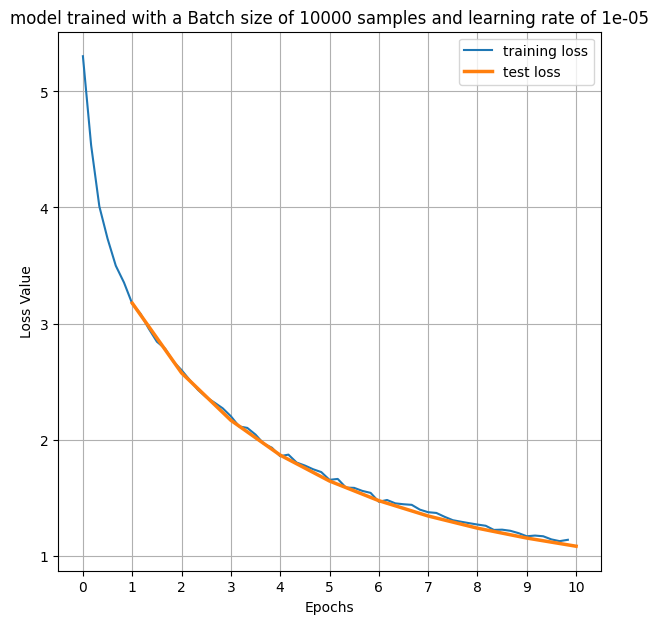

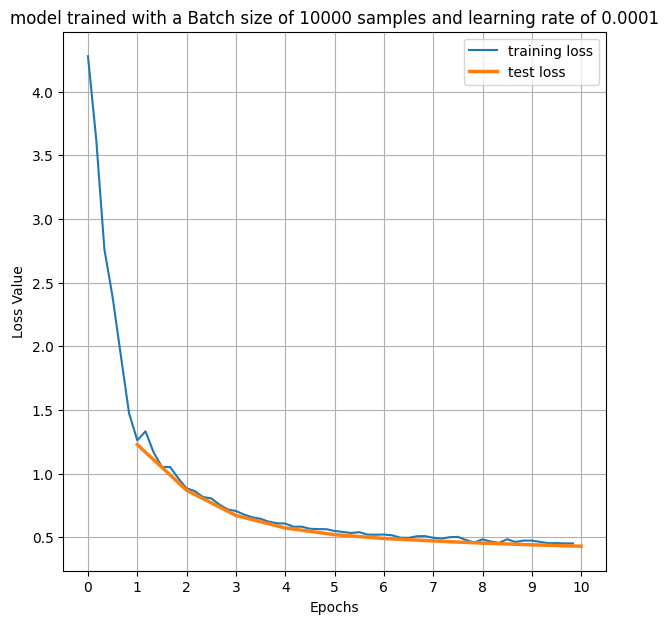

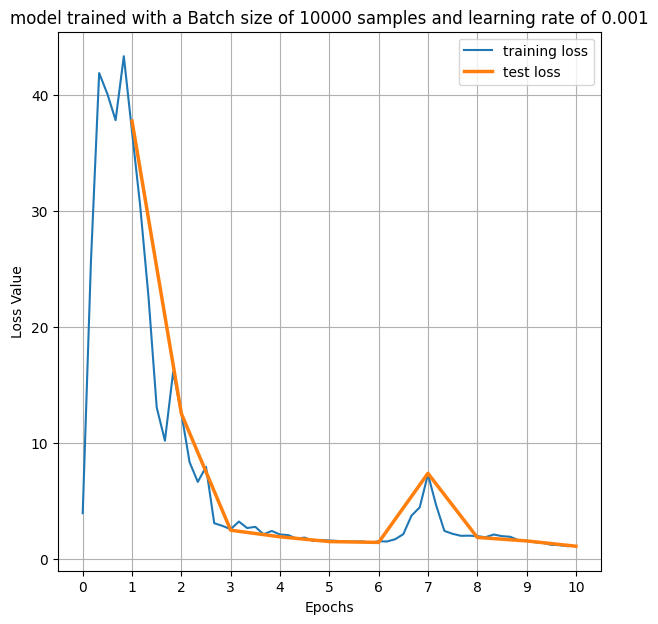

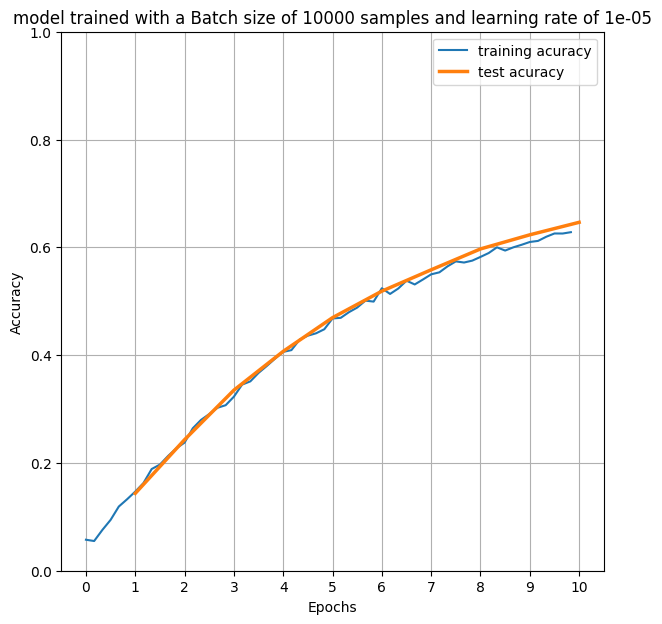

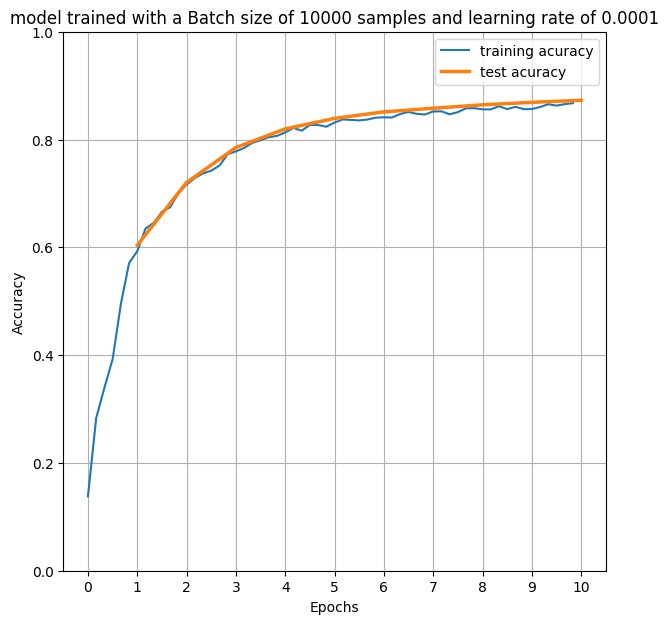

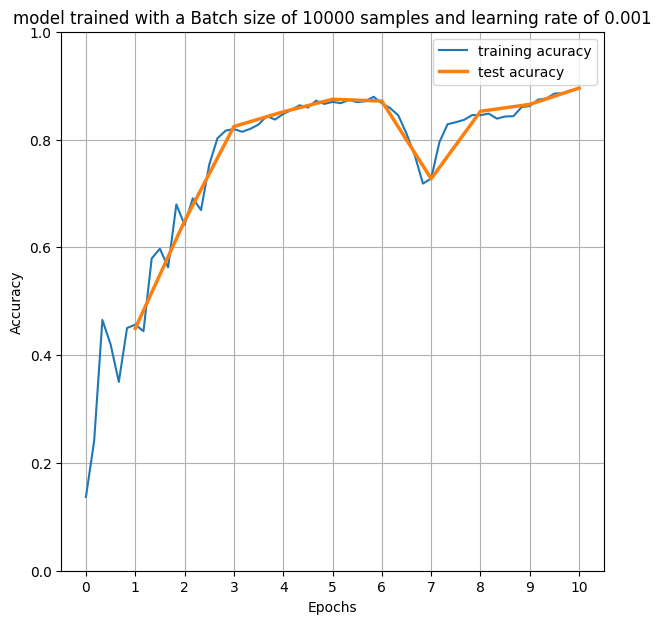

In [81]:
# Study of the effect of the learning rate

history    = {}
eta        = 1e-5 # learning rate
momentum   = 0.   # momemtum factor
N_EPOCHS   = 10   # number of epochs
BatchSizes = [10000] # try different batch sizes for the analysis

for eta in [1e-5,1e-4,1e-3]:

    print('learning rate=',eta)
    
    history[eta]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])
    
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        
        Batches=create_batches(Xtrain,BatchSizes[0])
        
        for batch in Batches:
            # Loop on the batches
            #print('epoch=',n,'batch=',batch.shape[0])
            
            # Store the previous weights
            wold = w
            # Store the previous gradients
            gradold = grad

            # Compute the gradient of the loss function and compute the training loss and accuracy
            train_acc  = 0
            train_loss = 0
            grad = np.zeros((10,Xtrain.shape[1]))
            for i in batch:
                ce, gradtemp, pred = f(w,Xtrain[i],targets_train[i])
                grad += gradtemp.reshape(10,Xtrain.shape[1])
                train_loss += ce
                train_acc  += np.argmax(pred)==np.argmax(targets_train[i])

            history[eta]['train loss'] += [train_loss/batch.shape[0]]
            history[eta]['train acc']  += [train_acc/batch.shape[0]]
        
            # Update the weights
            w = w - eta*grad + momentum*(w-wold)
                   
        # Test accuracy at the end of each epoch on the training set
        

        # Compute the test loss and accuracy
        test_loss = 0
        test_acc  = 0
        for i in range(Xtest.shape[0]):
            pred = NN(Xtest[i],w)
            test_loss += cross_entropy(pred,targets_test[i],Xtest[i])[0]
            test_acc  += np.argmax(pred)==np.argmax(targets_test[i])

        history[eta]['test loss'] += [test_loss/Xtest.shape[0]]
        history[eta]['test acc']  += [test_acc/Xtest.shape[0]]

        print('Epoch number :', n+1,'test accuracy:',history[eta]['test acc'][n+1],'test loss',history[eta]['test loss'][n+1])
        

    print('\n')

for eta in [1e-5,1e-4,1e-3]: 
    n_batch = Xtrain.shape[0]//BatchSizes[0]     
    if Xtrain.shape[0]%BatchSizes[0]!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[eta]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[eta]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {BatchSizes[0]} samples and learning rate of {eta}')
    plt.show()

for eta in [1e-5,1e-4,1e-3]:
    n_batch = Xtrain.shape[0]//BatchSizes[0]     
    if Xtrain.shape[0]%BatchSizes[0]!=0:
        n_batch+=1
        
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[eta]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[eta]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {BatchSizes[0]} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Sensivity to the momentum
Momentum involves adding an additional hyperparameter that controls the amount of history (momentum) to include in the update equation. The momentum hyperparameter must be chosen carefully, and often a value of 0.5 is used. A large momentum value can result in a model that learns very quickly but may not converge, whereas a small momentum value may result in a model that takes a long time to learn and may not converge.

momentum= 0.0
Epoch number : 1 test accuracy: 0.5904 test loss 1.489571676704565
Epoch number : 2 test accuracy: 0.7086 test loss 0.9144843150816471
Epoch number : 3 test accuracy: 0.781 test loss 0.6858843722794772
Epoch number : 4 test accuracy: 0.8199 test loss 0.5734751005061894
Epoch number : 5 test accuracy: 0.8339 test loss 0.5332281767275264
Epoch number : 6 test accuracy: 0.8449 test loss 0.500438165647559
Epoch number : 7 test accuracy: 0.8521 test loss 0.4777700811400682
Epoch number : 8 test accuracy: 0.8557 test loss 0.4627848089947758
Epoch number : 9 test accuracy: 0.8645 test loss 0.4467017228230656
Epoch number : 10 test accuracy: 0.8683 test loss 0.43316247326704327


momentum= 0.5
Epoch number : 1 test accuracy: 0.6099 test loss 1.2144205137962478
Epoch number : 2 test accuracy: 0.6954 test loss 0.9421678370665993
Epoch number : 3 test accuracy: 0.7788 test loss 0.689724575716058
Epoch number : 4 test accuracy: 0.8227 test loss 0.5708943708780568
Epoch number : 5 tes

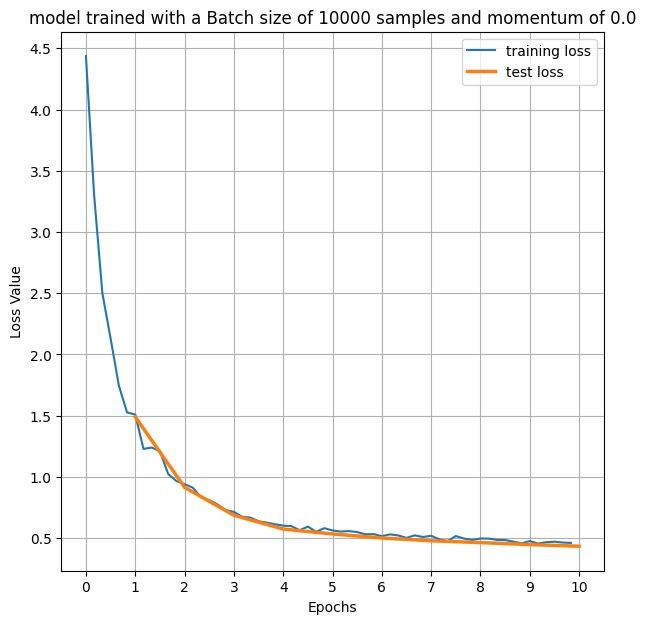

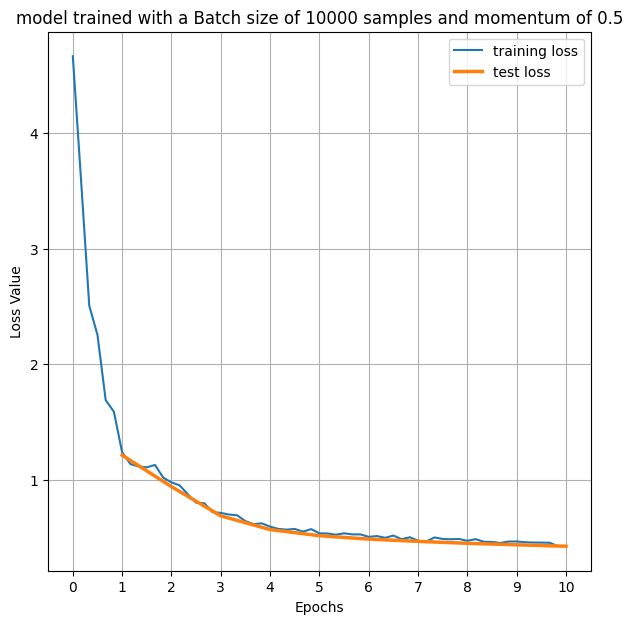

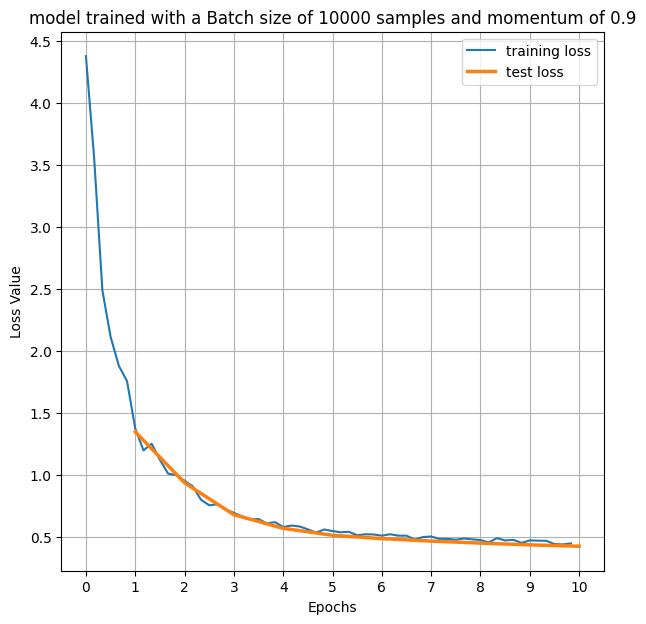

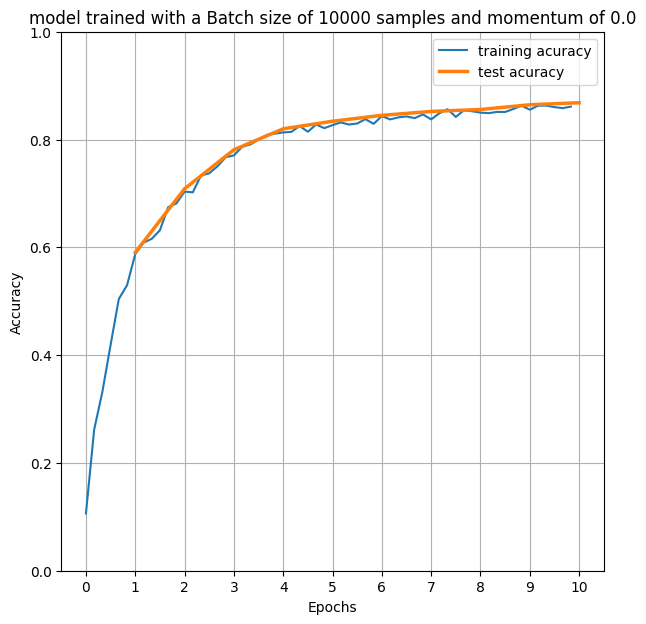

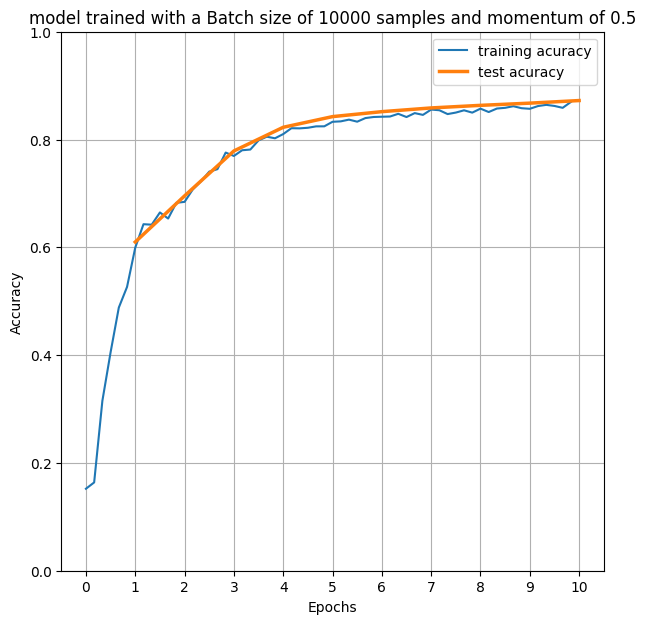

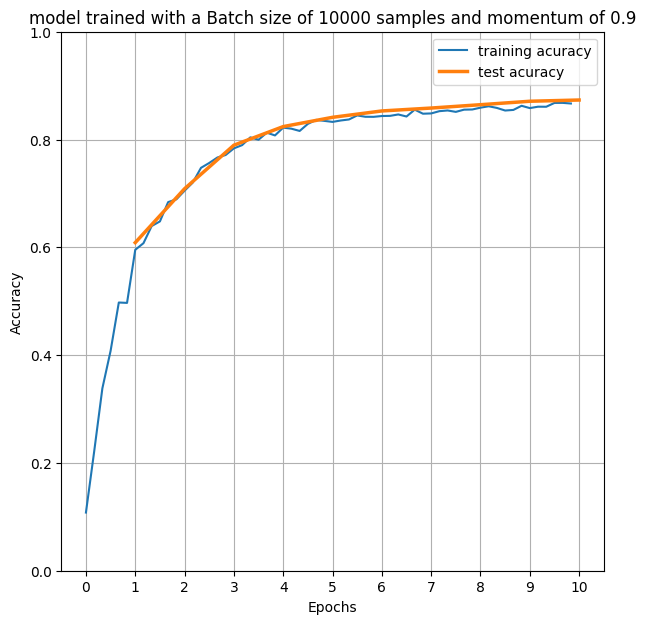

In [83]:
# Study of the effect of the momentum

history    = {}
eta        = 1e-4 # learning rate
momentum   = 0.   # momemtum factor
N_EPOCHS   = 10   # number of epochs
BatchSizes = [10000] # try different batch sizes for the analysis

for momentum in [0.,0.5,0.9]:
    
    print('momentum=',momentum)

    history[momentum]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}

    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])

    for n in range(N_EPOCHS):
        # Minimization of the loss function

        Batches=create_batches(Xtrain,BatchSizes[0])

        for batch in Batches:
            # Loop on the batches
            #print('epoch=',n,'batch=',batch.shape[0])

            # Store the previous weights
            wold = w
            # Store the previous gradients
            gradold = grad

            # Compute the gradient of the loss function and compute the training loss and accuracy
            train_acc  = 0
            train_loss = 0
            grad = np.zeros((10,Xtrain.shape[1]))
            for i in batch:
                ce, gradtemp, pred = f(w + momentum*(w-wold),Xtrain[i],targets_train[i])
                grad += gradtemp.reshape(10,Xtrain.shape[1])
                train_loss += ce
                train_acc  += np.argmax(pred)==np.argmax(targets_train[i])

            history[momentum]['train loss'] += [train_loss/batch.shape[0]]
            history[momentum]['train acc']  += [train_acc/batch.shape[0]]

            # Update the weights
            w = w - eta*grad + momentum*(w-wold)

        # Test accuracy at the end of each epoch on the training set


        # Compute the test loss and accuracy
        test_loss = 0
        test_acc  = 0
        for i in range(Xtest.shape[0]):
            pred = NN(Xtest[i],w)
            test_loss += cross_entropy(pred,targets_test[i],Xtest[i])[0]
            test_acc  += np.argmax(pred)==np.argmax(targets_test[i])

        history[momentum]['test loss'] += [test_loss/Xtest.shape[0]]
        history[momentum]['test acc']  += [test_acc/Xtest.shape[0]]

        print('Epoch number :', n+1,'test accuracy:',history[momentum]['test acc'][n+1],'test loss',history[momentum]['test loss'][n+1])

    print('\n')

for momentum in [0.,0.5,0.9]:
    n_batch = Xtrain.shape[0]//BatchSizes[0]     
    if Xtrain.shape[0]%BatchSizes[0]!=0:
        n_batch+=1
        
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[momentum]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[momentum]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {BatchSizes[0]} samples and momentum of {momentum}')
    plt.show()

for momentum in [0.,0.5,0.9]:
    n_batch = Xtrain.shape[0]//BatchSizes[0]     
    if Xtrain.shape[0]%BatchSizes[0]!=0:
        n_batch+=1
        
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[momentum]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[momentum]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {BatchSizes[0]} samples and momentum of {momentum}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()
